In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
plt.style.use("ggplot")

We load both datasets, `tickets` and `cycles`:

In [2]:
DATA_PATH = '../data/'
tickets = pd.read_csv(DATA_PATH + 'tickets_processed.csv')
cycles = pd.read_csv(DATA_PATH + 'analytics_processed.csv')

As they contain date attributes, we convert them to `datetime` in order to ease date selection.

In [3]:
tickets['datetime'] = pd.to_datetime(tickets['datetime'], format = "%Y-%m-%d %H:%M:%S")
cycles['first_timestamp'] = pd.to_datetime(cycles['first_timestamp'], format = "%Y-%m-%d %H:%M:%S")
cycles['last_timestamp'] = pd.to_datetime(cycles['last_timestamp'], format = "%Y-%m-%d %H:%M:%S")

#### Intro

- Explanation of the exploration analysis and visualization of the data we have in order to get useful and explanatory insights.
- We make use of the versatility of Python Jupyter Notebook (.ipynb) as it allows to quickly process the data and see the visualizations that we are creating instantly.
- The Python libraries that have been used are, in essence: Pandas, Numpy, Matplotlib and Datetime.


### 1. Preview of Tickets and Cycles dataframes

Firstly, we show a preview of both dataframes and get the number of rows we have: **557,817** for **Tickets** and **1,048,265** for **Cycles**.

In [4]:
tickets.head()

,ticket_id,client,store,datetime
0,1,161600,8136,2015-05-25 11:13:52
1,2,82155,8136,2015-05-25 11:52:42
2,3,202968,8136,2015-05-25 12:30:50
3,4,609861,8136,2015-05-25 13:35:32
4,5,84568,8136,2015-05-25 17:32:34


In [5]:
print(f'Number of tickets: {len(tickets):,d}')

Number of tickets: 557,817


In [6]:
cycles.head()

,local,hash,first_timestamp,last_timestamp
0,7633,484858492120526,2020-02-13 18:05:10,2020-02-13 18:15:02
1,7633,462419088891167,2020-02-13 09:35:16,2020-02-13 09:40:32
2,7633,370013777344297,2020-02-13 11:00:39,2020-02-13 11:02:57
3,7633,409386925116844,2020-02-13 17:00:23,2020-02-13 18:21:36
4,7633,479623648581674,2020-02-13 12:50:34,2020-02-13 12:54:02


In [7]:
print(f'Number of cycles: {len(cycles):,d}')

Number of cycles: 1,048,265


### 2. Unique values of each column

We display how many unique values exist for each attribute (i.e. `ticket_id`, `client`, `store`, `datetime` for Tickets and `local`, `hash`, `first_timestamp`, `last_timestamp` for Cycles) and the percentage of uniqueness with respect to all observations:

In [8]:
def CountUniques(df):
    n_unique = {}
    pct_unique = {}
    rows = len(df)
    for i in range(df.shape[1]):
        col = df.columns[i]
        n_unique[col] = df[col].nunique()
        pct_unique[col] = n_unique[col] / rows
    f = pd.DataFrame([n_unique, pct_unique], index = ['n_unique','pct_unique']).transpose()
    f['n_unique'] = f['n_unique'].astype(int)
    return f

In [9]:
CountUniques(tickets)

,n_unique,pct_unique
ticket_id,557817,1.000000
client,162914,0.292056
store,17,0.000030
datetime,547576,0.981641


In [10]:
CountUniques(cycles)

,n_unique,pct_unique
local,20,0.000019
hash,540970,0.516062
first_timestamp,1025463,0.978248
last_timestamp,1026005,0.978765


Notice we have some timestamps (for both, `first` and `last`) that coincide at exactly the same time.

### 3. Dates ranges

In order to have an idea of the length of the data in terms of time (that is which period spans our data), we compute the time difference between oldest and most recent dates for attributes `datetime`, `first_timestamp` and `last_timestamp`:

In [11]:
def DatesRange(df, column = 'datetime'):
    datepoints = pd.Series(df[column].copy().unique())
    datepoints = datepoints.sort_values().reset_index(drop=True)
    start_date = datepoints[0]
    end_date = datepoints[len(datepoints)-1]
    print('     oldest date: ', start_date)
    print('most recent date: ', end_date)
    difference_in_years = relativedelta(end_date, start_date)
    print(difference_in_years)

In [12]:
DatesRange(tickets)

     oldest date:  2014-01-04 10:04:20
most recent date:  2018-07-19 21:15:40
relativedelta(years=+4, months=+6, days=+15, hours=+11, minutes=+11, seconds=+20)


In [13]:
DatesRange(cycles, 'first_timestamp')

     oldest date:  2015-12-31 00:00:07
most recent date:  2020-02-13 19:43:42
relativedelta(years=+4, months=+1, days=+13, hours=+19, minutes=+43, seconds=+35)


In [14]:
DatesRange(cycles, 'last_timestamp')

     oldest date:  2015-12-31 00:08:30
most recent date:  2020-02-13 19:45:43
relativedelta(years=+4, months=+1, days=+13, hours=+19, minutes=+37, seconds=+13)


#### 3.1. Unique values only for Cycles period

In [15]:
first_cycle = cycles.sort_values('first_timestamp')
first_cycle = first_cycle.iloc[0]['first_timestamp']
CountUniques(tickets[tickets['datetime'] >= first_cycle])

,n_unique,pct_unique
ticket_id,352686,1.000000
client,124874,0.354066
store,17,0.000048
datetime,347457,0.985174


We have sorted all Cycles dataset by `first_timestamp`, we selected the first Cycle (the oldest one) and filtered Tickets dataset from this date onwards. We see, now we count **124.874** unique clients, while in the original dataset there are **162.914**.

#### 3.2. Unique values by store only for interection of Tickets and Cycles

In [16]:
def IntersectByStore(tickets, cycles):
    filtered_tickets, filtered_cycles = pd.DataFrame(), pd.DataFrame()
    stores = tickets['store'].unique()
    print(f"Processing {len(stores)} stores:")
    for store in stores:
        # Get tickets and cycles of a given store.
        store_tickets = tickets[tickets['store'] == store]
        store_cycles = cycles[cycles['local'] == store]
        # Sort them out.
        store_tickets = store_tickets.sort_values('datetime')
        store_cycles = store_cycles.sort_values('first_timestamp')
        # Get first and last row (with all columns!)
        first_ticket, last_ticket = store_tickets.iloc[0], store_tickets.iloc[-1]
        first_cycle, last_cycle = store_cycles.iloc[0], store_cycles.iloc[-1]
        # Compute the intersection interval between timestamps of both tickets and cycles.
        if (last_ticket['datetime'] < first_cycle['first_timestamp'] or last_cycle['first_timestamp'] < first_ticket['datetime']):
            print(f"No intersecction for store {store}!")
            break
        else:
            print(f"{store} ", end='')
            start = max(first_ticket['datetime'], first_cycle['first_timestamp'])
            end = min(last_ticket['datetime'], last_cycle['first_timestamp'])
        # Select only those tickets/cycles between the interection interval dates.
        store_tickets = store_tickets[start <= store_tickets['datetime']]
        store_tickets = store_tickets[store_tickets['datetime'] <= end]
        store_cycles = store_cycles[start <= store_cycles['first_timestamp']]
        store_cycles = store_cycles[store_cycles['first_timestamp'] <= end]
        # Append the filtered tickets/cycles of the current store to the output dataframes.
        filtered_tickets = filtered_tickets.append(store_tickets)
        filtered_cycles = filtered_cycles.append(store_cycles)
    return(filtered_tickets, filtered_cycles)

In [17]:
intersected_tickets, intersected_cycles = IntersectByStore(tickets, cycles)

Processing 17 stores:
8136 7634 7606 8139 8135 8123 8126 7633 8142 8138 7635 8127 8124 8140 8137 8141 9213 

In [18]:
CountUniques(intersected_tickets)

,n_unique,pct_unique
ticket_id,350673,1.000000
client,124054,0.353760
store,17,0.000048
datetime,345481,0.985194


We see a slight decrease in the number of unique clients, **124.054**, while in the original dataset there are **162.914**. Notice we now have a few less unique clients than when we didn't separate by store (in section `3.1`), where we had **124.874**.

In [19]:
CountUniques(intersected_cycles)

,n_unique,pct_unique
local,17,0.000017
hash,515356,0.512002
first_timestamp,985414,0.979002
last_timestamp,985887,0.979471


We see a slight decrease in the number of unique hashes, **515.356**, while in the original dataset there are **540.970**.

#### 3.3. IntersectByStoreAndDay

In [90]:
def IntersectByStoreAndDay(tickets, cycles):
    filtered_tickets, filtered_cycles = pd.DataFrame(), pd.DataFrame()
    stores = tickets['store'].unique()
    print(f"Processing {len(stores)} stores:")
    for store in stores:
        print(f"{store} ", end='')
        # Get tickets and cycles of a given store.
        store_tickets = tickets.copy()[tickets['store'] == store]
        store_cycles = cycles.copy()[cycles['local'] == store]
        # Create new column with only the YYYY-MM-DD of the timestamps.
        store_tickets['day'] = store_tickets['datetime'].dt.date
        store_cycles['day'] = store_cycles['first_timestamp'].dt.date
        # Get list of days of both tickets and cycles.
        tickets_days = store_tickets['day'].unique()
        cycles_days = store_cycles['day'].unique()
        # Keep only the intersection of days.
        intersec = np.intersect1d(tickets_days, cycles_days)
        # Select only those tickets/cycles with days belonging to the intersection. 
        store_tickets = store_tickets[store_tickets['day'].isin(intersec)]
        store_cycles = store_cycles[store_cycles['day'].isin(intersec)]
        # Append the filtered tickets/cycles of the current store to the output dataframes.
        filtered_tickets = filtered_tickets.append(store_tickets)
        filtered_cycles = filtered_cycles.append(store_cycles)
    return(filtered_tickets, filtered_cycles)

In [91]:
intersected_tickets, intersected_cycles = IntersectByStoreAndDay(tickets, cycles)

Processing 17 stores:
8136 7634 7606 8139 8135 8123 8126 7633 8142 8138 7635 8127 8124 8140 8137 8141 9213 

In [92]:
CountUniques(intersected_tickets)

,n_unique,pct_unique
ticket_id,330328,1.000000
client,120195,0.363866
store,17,0.000051
datetime,325625,0.985763
day,887,0.002685


In [93]:
CountUniques(intersected_cycles)

,n_unique,pct_unique
local,17,0.000019
hash,475354,0.528779
first_timestamp,879943,0.978839
last_timestamp,880379,0.979324
day,887,0.000987


#### 3.4. Explore margin between consecutive timestamps

In [20]:
sorted_tickets = tickets[tickets['datetime'] >= first_cycle]
sorted_tickets = sorted_tickets.sort_values('datetime')
sorted_tickets['diff_datetime'] = sorted_tickets['datetime'].diff()
sorted_tickets['diff_datetime_minutes'] = sorted_tickets['diff_datetime'] / np.timedelta64(1, 's')

**Mean** between each consecutive Ticket timestamp:

In [21]:
str(timedelta(minutes=sorted_tickets['diff_datetime_minutes'].mean()))

'3:48:11.268639'

**Median** between each consecutive Ticket timestamp:

In [22]:
str(timedelta(minutes=sorted_tickets['diff_datetime_minutes'].median()))

'0:51:00'

In [23]:
sorted_cycles = cycles.sort_values('first_timestamp')
sorted_cycles['first_timestamp_diff'] = sorted_cycles['first_timestamp'].diff()
sorted_cycles['first_timestamp_diff_minutes'] = sorted_cycles['first_timestamp_diff'] / np.timedelta64(1, 's')

**Mean** between each consecutive Cycle timestamp:

In [24]:
str(timedelta(minutes=sorted_cycles['first_timestamp_diff_minutes'].mean()))

'2:04:06.769993'

**Median** between each consecutive Cycle timestamp:

In [25]:
str(timedelta(minutes=sorted_cycles['first_timestamp_diff_minutes'].median()))

'0:20:00'

### 4. Plots of non-temporal variables

In order to better interpret the plots, you need to have in mind the chosen color guidelines. In general:
- <font color='darkorange'>ORANGE</font> refers to <font color='darkorange'>tickets</font>
- <font color='limegreen'>GREEN</font> refers to <font color='limegreen'>unique clients</font>
- <font color='lightskyblue'>LIGHT BLUE</font> refers to <font color='lightskyblue'>hashes</font>
- <font color='royal blue'>BLUE</font> refers to <font color='royal blue'>unique hashes</font>
- <font color='mediumorchid'>VIOLET</font> refers to <font color='mediumorchid'>ratios</font> between variables
- <font color='darkred'>RED</font> refers to <font color='darkred'>missing values</font>

#### 4.1. Plots based on Stores

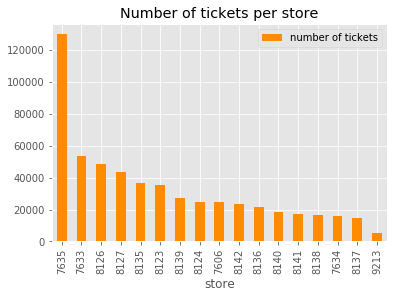

In [26]:
stores_tickets = tickets.groupby('store').count()
stores_tickets = stores_tickets[['ticket_id']].reset_index()
stores_tickets = stores_tickets.rename({'ticket_id': 'number of tickets'}, axis=1)
stores_tickets = stores_tickets.sort_values('number of tickets', ascending=False)
stores_tickets.plot.bar('store','number of tickets', title='Number of tickets per store', color='darkorange', figsize=(6,4))
plt.show()

The number of tickets by store is very unbalanced, in general. The store 7635 owns more than **23%** of the tickets and from second to penultimate (in decreasing order) there are small differences. However, if we compare the first and last store, 7635 and 9213, respectively, they differ by a factor of more than **24** (that is, more than **120.000** tickets). 

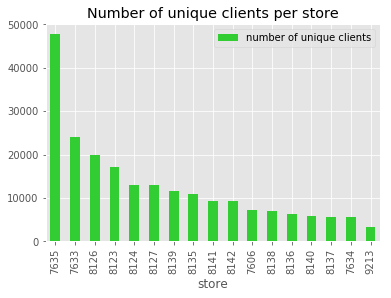

In [27]:
stores_clients = tickets.groupby('store').client.nunique()
stores_clients = stores_clients.reset_index()
stores_clients = stores_clients.rename({'client': 'number of unique clients'}, axis=1)
stores_clients = stores_clients.sort_values('number of unique clients', ascending=False)
stores_clients.plot.bar('store','number of unique clients', title='Number of unique clients per store', color='limegreen', figsize=(6,4))
plt.show()

The number of unique clients by store essentially follows the same trend as the tickets. So, it can be applied what has been said before. Just note that now the magnitude of the values has decreased to about **half** the number of the tickets for each store. Furthermore, there is no doubt that customers are shared among stores, since the sum of unique customers for each store, i.e. **217.097**, far exceeds the number of unique customers present in the dataset, i.e. **162.914**.

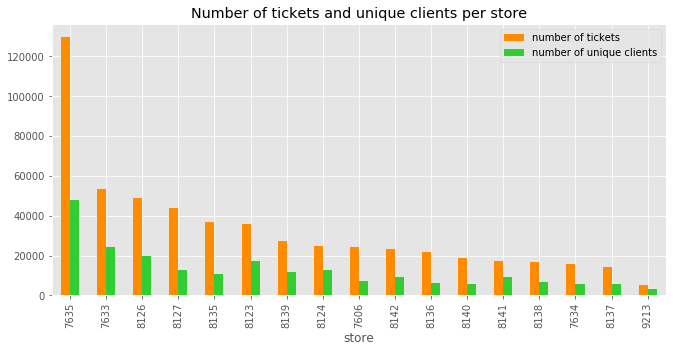

In [28]:
stores_tickets_clients = pd.merge(stores_tickets, stores_clients, how='outer', left_on=['store'], right_on=['store'])
stores_tickets_clients.plot.bar('store', color=['darkorange','limegreen'], figsize=(11,5), title='Number of tickets and unique clients per store')
plt.show()

The significant difference between the number of tickets and the number of unique clients by store can be seen with the naked eye. Indeed, it is confirmed that there are around **twice** as many tickets as unique clients. This could lead us to think that, roughly speaking, each customer makes around **2** purchases in a single store (but the distribution of purchases may actually be very skewed for each client). 

#### 4.2. Plots based on Locals

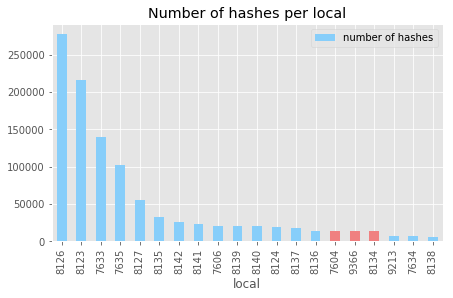

In [29]:
locals_hashes = cycles.groupby('local').count()
locals_hashes = locals_hashes[['hash']].reset_index()
locals_hashes = locals_hashes.rename({'hash': 'number of hashes'}, axis=1)
locals_hashes = locals_hashes.sort_values('number of hashes', ascending=False)
locals_hashes.plot.bar('local','number of hashes', title='Number of hashes per local',
                       color=['lightskyblue' if x in stores_tickets['store'].unique() else 'lightcoral' for x in locals_hashes['local']],
                       figsize=(7,4))
plt.show()

The number of hashes per location is extremely unbalanced and, on top of that, there are few stores with a lot of hashes and there are many stores with very few hashes (so, the character of the data is that of a power law). This drastic difference can be seen if we compare the first and last local, 8126 and 8138, respectively, as they differ by a factor of more than **49** (that is, more than **270.000** hashes). We also note that there are **3** locals (7604, 9366 and 8134; the red ones) which do not appear in the Tickets dataset and, therefore, this hashes' data is thrown away. At least, since they do not represent a sheer volume of hashes, it is not a major concern.

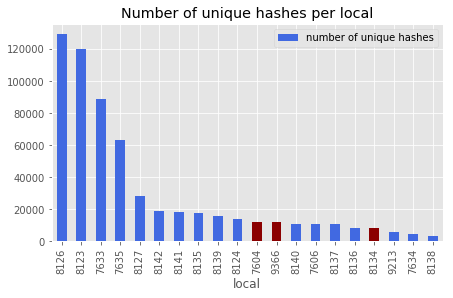

In [30]:
locals_uniqueHashes = cycles.groupby('local').hash.nunique()
locals_uniqueHashes = locals_uniqueHashes.reset_index()
locals_uniqueHashes = locals_uniqueHashes.rename({'hash': 'number of unique hashes'}, axis=1)
locals_uniqueHashes = locals_uniqueHashes.sort_values('number of unique hashes', ascending=False)
locals_uniqueHashes.plot.bar('local','number of unique hashes', title='Number of unique hashes per local',
                             color=['royalblue' if x in stores_tickets['store'].unique() else 'darkred' for x in locals_uniqueHashes['local']],
                             figsize=(7,4))
plt.show()

The number of unique hashes by local essentially follows the same trend as the (non-unique) hashes. Just note that now the magnitude of the values has decreased to about **half** the number of the (non-unique) hashes for each local. Furthermore, we state that unique hashes are shared among locals (but not too much), since the sum of unique hashes for each local, i.e. **603.377**, is a little bit higher than the number of unique hashes present in the dataset, i.e. **540.970**.

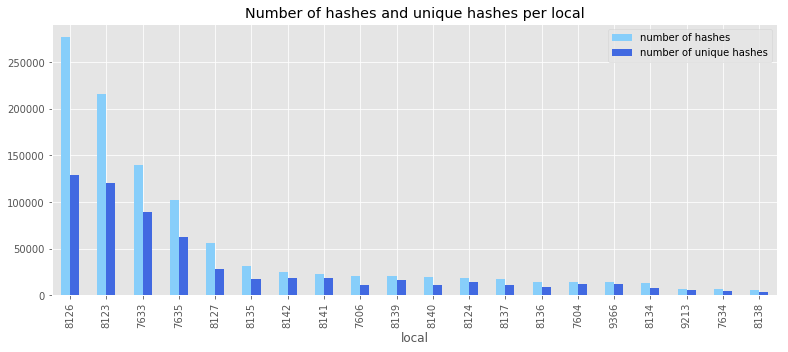

In [31]:
locals_hashes_uniqueHashes = pd.merge(locals_hashes, locals_uniqueHashes, how='outer', left_on=['local'], right_on=['local'])
locals_hashes_uniqueHashes.plot.bar('local', color=['lightskyblue','royalblue'],
                                    figsize=(13,5), title='Number of hashes and unique hashes per local')
plt.show()

The significant difference between the number of hashes and the number of unique hashes per local can be seen with the naked eye. But this variation only occurs in the few locals that have a lot of hashes, since the difference is accentuated. In the rest of the locals, we can say that enough of them have almost the same amount of unique hashes and (non-unique) hashes. The above could lead us to think that, roughly speaking, each customer visits around **2** times each local (for locals with a sheer volume of hashes) and around **1** time or a bit more each local (for locals with few hashes).

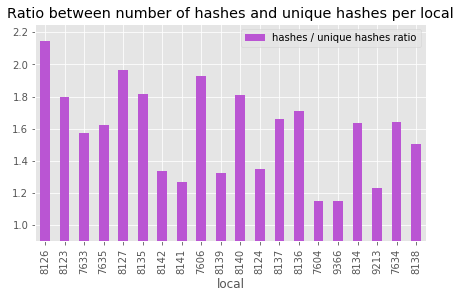

In [32]:
locals_hashes_uniqueHashes['hashes / unique hashes ratio'] = locals_hashes_uniqueHashes['number of hashes'] / locals_hashes_uniqueHashes['number of unique hashes']
locals_hashes_uniqueHashes.plot.bar('local','hashes / unique hashes ratio', color='mediumorchid', figsize=(7,4),
                                  title='Ratio between number of hashes and unique hashes per local')
plt.ylim(bottom=min(locals_hashes_uniqueHashes['hashes / unique hashes ratio'])-0.25)
plt.show()


The ratio between the number of (non-unique) hashes and the number of unique hashes per local reflects the high variability of uniqueness in hashes, as we expected. Anyway, this variation is between a little more than **1**, and **2**.

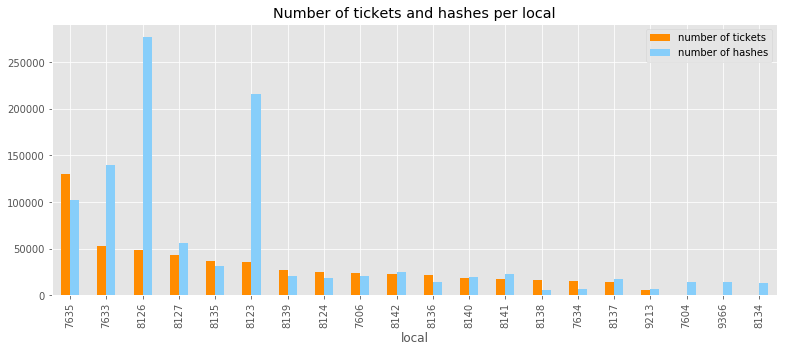

In [33]:
locals_tickets_hashes = pd.merge(stores_tickets, locals_hashes, how='right', left_on=['store'], right_on=['local'])
locals_tickets_hashes = locals_tickets_hashes.drop(['store'], axis=1)
locals_tickets_hashes.plot.bar('local', color=['darkorange','lightskyblue'], figsize=(13,5), title='Number of tickets and hashes per local')
plt.show()

The number of tickets per local is a little bit higher than (non-unique) hashes but very close to the same quantity, in general. Again, the above only applies for those locals with a low volume of hashes. Hence, for instance, for locals 7633, 8126 and 8123 (those with a lot of hashes), the difference is huge, and this large number of hashes and the low number of tickets portends a challenging matching. Notice locals 7604, 9366 and 8134 do not have any Tickets data.

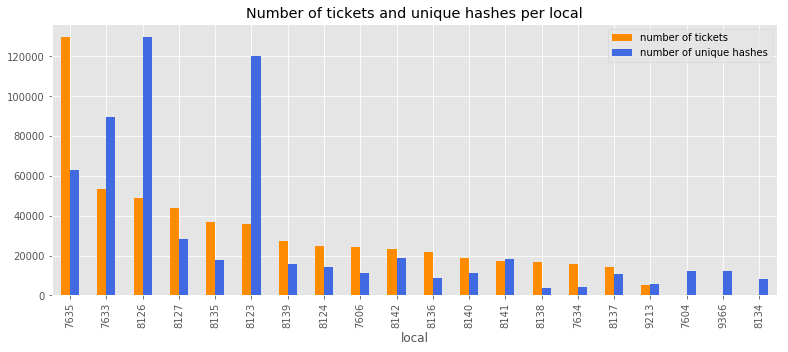

In [34]:
locals_tickets_uniqueHashes = pd.merge(stores_tickets, locals_uniqueHashes, how='right', left_on=['store'], right_on=['local'])
locals_tickets_uniqueHashes = locals_tickets_uniqueHashes.drop(['store'], axis=1)
locals_tickets_uniqueHashes.plot.bar('local', color=['darkorange','royalblue'], figsize=(13,5), title='Number of tickets and unique hashes per local')
plt.show()

The number of tickets and uniques hashes per local follows a similar trend in comparison with the (non-unique) hashes. Overall, the magnitude of difference between the volume of tickets and unique hashes has decreased. However, there appears to be greater variability between stores, especially those with few tickets: some of these have very few unique hashes compared to tickets. Again, locals 7604, 9366 and 8134 do not have any Tickets data.

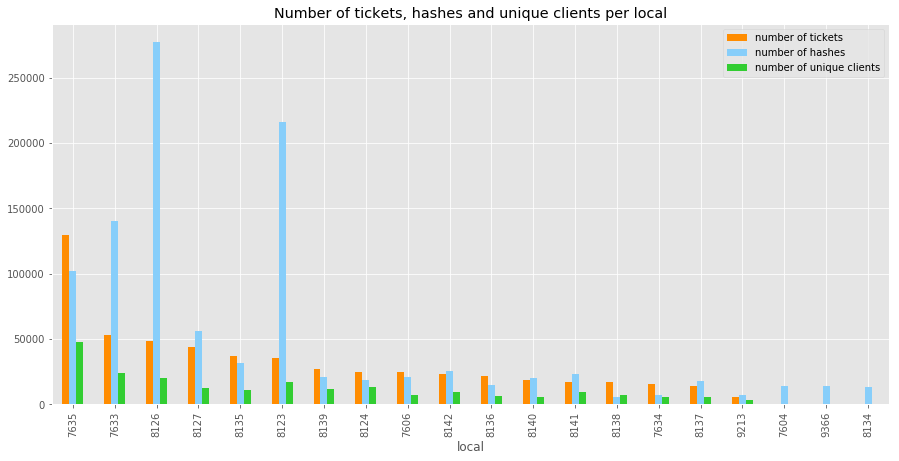

In [35]:
locals_tickets_hashes_clients = pd.merge(locals_tickets_hashes, stores_clients, how='left', left_on=['local'], right_on=['store'])
locals_tickets_hashes_clients = locals_tickets_hashes_clients.drop(['store'], axis=1)
locals_tickets_hashes_clients.plot.bar('local', color=['darkorange','lightskyblue','limegreen'], figsize=(15,7), title='Number of tickets, hashes and unique clients per local')
plt.show()

Showing together the three related variables: tickets, hashes and unique clients, we observe that while the number of unique clients is almost half the number of tickets, when we compare to hashes the difference is humongous for those locals that have too many hashes.

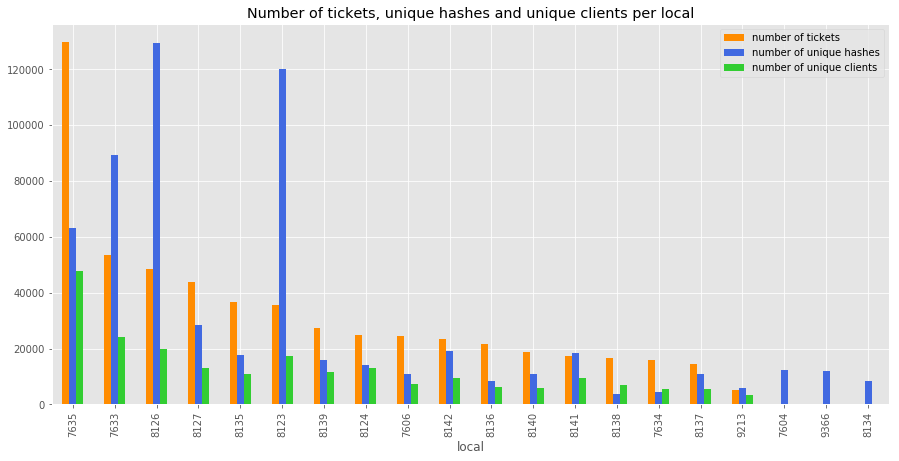

In [36]:
locals_tickets_uniqueHashes_clients = pd.merge(locals_tickets_uniqueHashes, stores_clients, how='left', left_on=['local'], right_on=['store'])
locals_tickets_uniqueHashes_clients = locals_tickets_uniqueHashes_clients.drop(['store'], axis=1)
locals_tickets_uniqueHashes_clients.plot.bar('local', color=['darkorange','royalblue','limegreen'], figsize=(15,7), title='Number of tickets, unique hashes and unique clients per local')
plt.show()

The comparison of the number of tickets, unique hashes and uniques clients comforts us a little bit, as when counting unique hashes, values drop noticeably. However, the trend is the same as before: some locals own huge differences between tickets and hashes, and the general rule is there is quite a few more tickets than unique hashes.

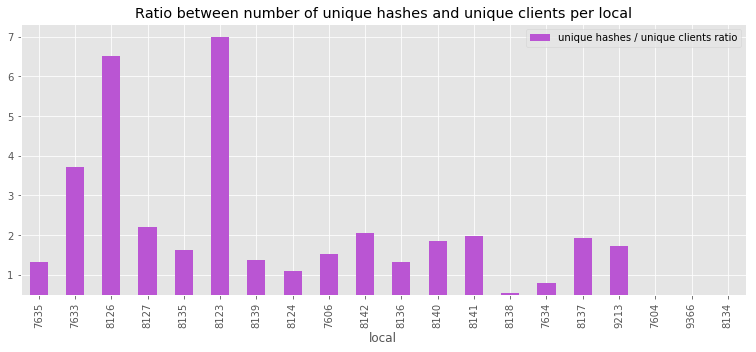

In [37]:
locals_tickets_uniqueHashes_clients['unique hashes / unique clients ratio'] = locals_tickets_uniqueHashes_clients['number of unique hashes'] / locals_tickets_uniqueHashes_clients['number of unique clients']
locals_tickets_uniqueHashes_clients.plot.bar('local','unique hashes / unique clients ratio', color='mediumorchid', figsize=(13,5),
                                  title='Ratio between number of unique hashes and unique clients per local')
plt.ylim(bottom=min(locals_tickets_uniqueHashes_clients['unique hashes / unique clients ratio'])-0.05)
plt.show()

The high variability between the number of unique hashes and unique clients among locals it is confirmed. For some of them the ratio exceeds the **6** points and for other barely reaches **1**.

### 5. Plots of temporal variables

#### 5.1. Evolution of Tickets dataframe

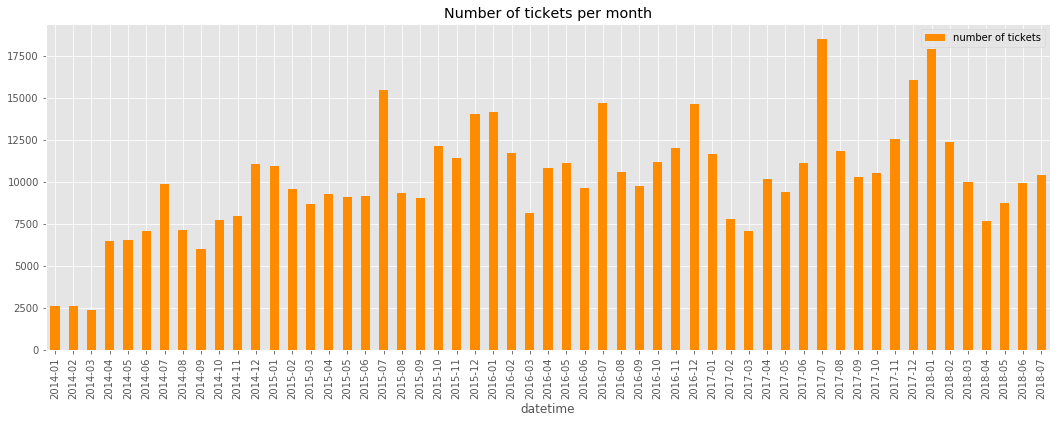

In [38]:
monthly_tickets = tickets.copy()
monthly_tickets['datetime'] = pd.DatetimeIndex(monthly_tickets['datetime']).strftime('%Y-%m')
datetime_tickets = monthly_tickets.copy().groupby('datetime').count()
datetime_tickets = datetime_tickets.drop(['client','store'], axis=1).reset_index()
datetime_tickets = datetime_tickets.rename({'ticket_id': 'number of tickets'}, axis=1)
datetime_tickets['datetime'] = datetime_tickets['datetime'].astype('O')
datetime_tickets.plot.bar('datetime','number of tickets', color='darkorange', figsize=(18,6), title='Number of tickets per month')
plt.show()

The number of tickets per month follows a distribution that could be considered equiprobable. It is clear that there are months that the number of tickets skyrockets but the differences are only a few tens of thousands, which does not imply a concern.

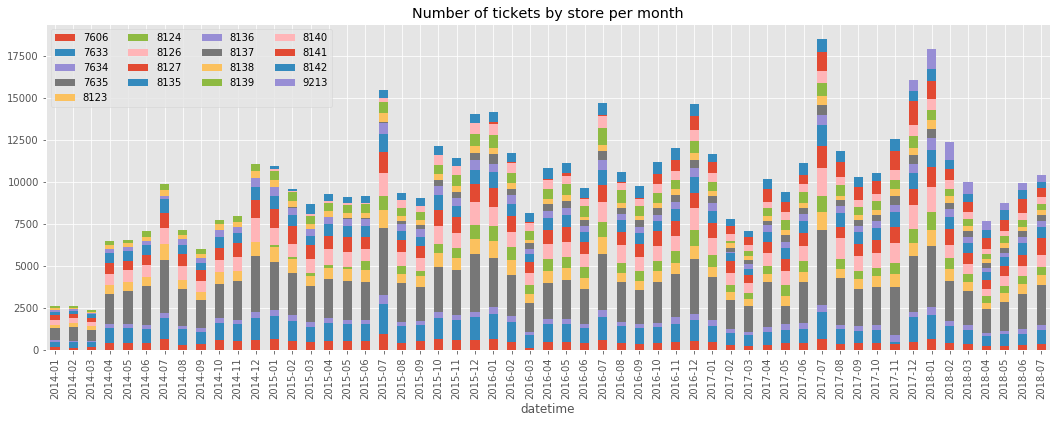

In [39]:
datetime_tickets_store = monthly_tickets.copy().groupby(['datetime','store']).count()
datetime_tickets_store = datetime_tickets_store.drop(['client'], axis=1).reset_index()
datetime_tickets_store = datetime_tickets_store.rename({'ticket_id': 'number of tickets'}, axis=1)
datetime_tickets_store['datetime'] = datetime_tickets_store['datetime'].astype('O')
datetime_tickets_store = datetime_tickets_store.pivot(index='datetime', columns='store', values='number of tickets')
datetime_tickets_store.plot.bar(stacked=True, figsize=(18,6), title='Number of tickets by store per month')
plt.legend(ncol=4)
plt.show()

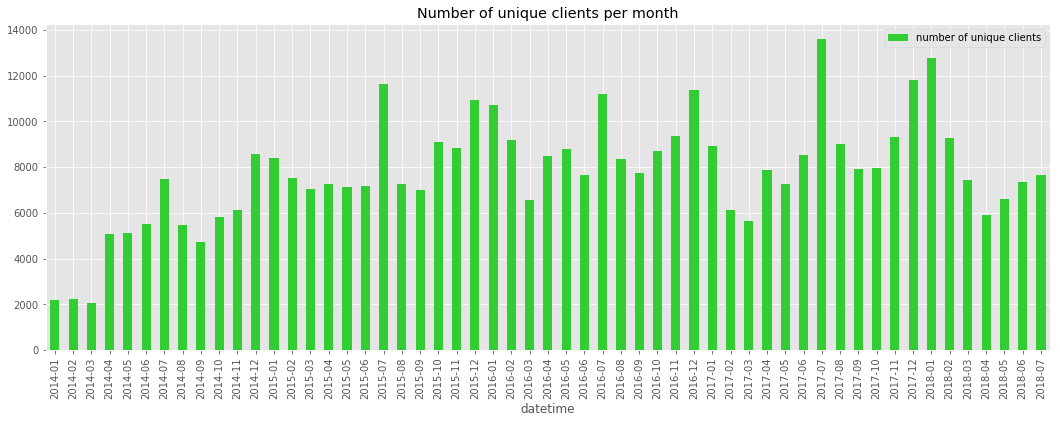

In [40]:
datetime_clients = monthly_tickets.copy().groupby('datetime').client.nunique()
datetime_clients = datetime_clients.reset_index()
datetime_clients = datetime_clients.rename({'client': 'number of unique clients'}, axis=1)
datetime_clients['datetime'] = datetime_clients['datetime'].astype('O')
datetime_clients.plot.bar('datetime','number of unique clients', color='limegreen', figsize=(18,6), title='Number of unique clients per month')
plt.show()

The number of unique clients per month seems to virtually follow the exact same trend, as no overly drastic changes are observed overall. Just notice the magnitude of the number of unique clients has decreased to about **a quarter** of the number of the tickets for each month, as we expected.

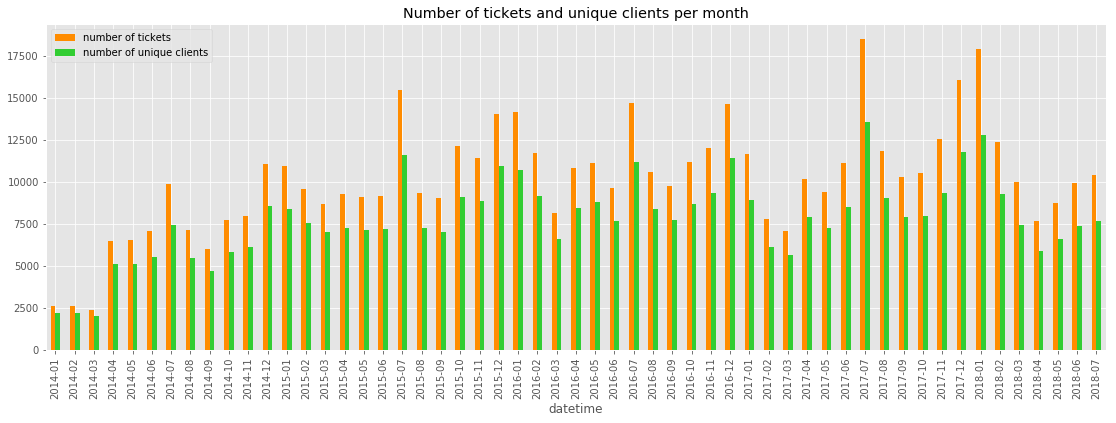

In [41]:
datetime_tickets_clients = pd.merge(datetime_tickets, datetime_clients, how='outer', left_on=['datetime'], right_on=['datetime'])
datetime_tickets_clients.plot.bar('datetime', color=['darkorange','limegreen'], figsize=(19,6), title='Number of tickets and unique clients per month')
plt.show()

When jointly plotting both number of tickets and unique clients, the drop of **a quarter** of the tickets in the number of unique clients per month is obvious, as we stated above. Furthermore, this difference is kept throughout every month, with barely noticeable differences. This fact reinforces the idea that each client makes at least more than **1** purchase every month.

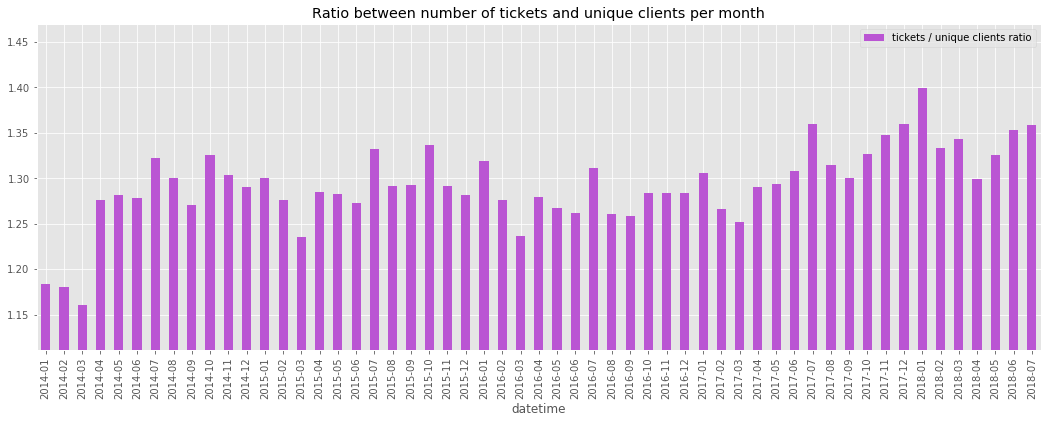

In [42]:
datetime_tickets_clients['tickets / unique clients ratio'] = datetime_tickets_clients['number of tickets'] / datetime_tickets_clients['number of unique clients']
datetime_tickets_clients.plot.bar('datetime','tickets / unique clients ratio', color='mediumorchid', figsize=(18,6),
                                  title='Ratio between number of tickets and unique clients per month')
plt.ylim(bottom=min(datetime_tickets_clients['tickets / unique clients ratio'])-0.05)
plt.show()

The ratio between the number of tickets and the number of unique clients per month reflects the constant difference between the number of tickets and customers. Moreover, now it is perceived what is the number of monthly purchases made by a customer: **1.3** on average.

#### 5.2. Evolution of Cycles dataframe

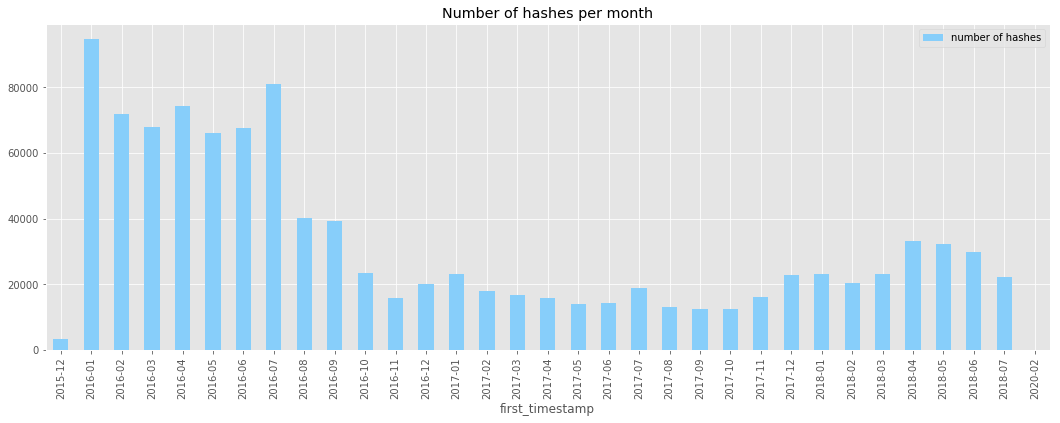

In [43]:
monthly_cycles = cycles.copy()
monthly_cycles['first_timestamp'] = pd.DatetimeIndex(monthly_cycles['first_timestamp']).strftime('%Y-%m')
first_hashes = monthly_cycles.copy().groupby('first_timestamp').count()
first_hashes = first_hashes.drop(['local','last_timestamp'], axis=1).reset_index()
first_hashes = first_hashes.rename({'hash': 'number of hashes'}, axis=1)
first_hashes['first_timestamp'] = first_hashes['first_timestamp'].astype('O')
first_hashes.plot.bar('first_timestamp','number of hashes', color='lightskyblue', figsize=(18,6), title='Number of hashes per month')
plt.show()

Again, the number of hashes per month brings up the idea that they constitute a high unbalanced set. More specifically, for the oldest dates, basically the year 2016, the number of hashes is very high, but later, despite having a decrease in volume, the quantities remain more or less constant until 2018.

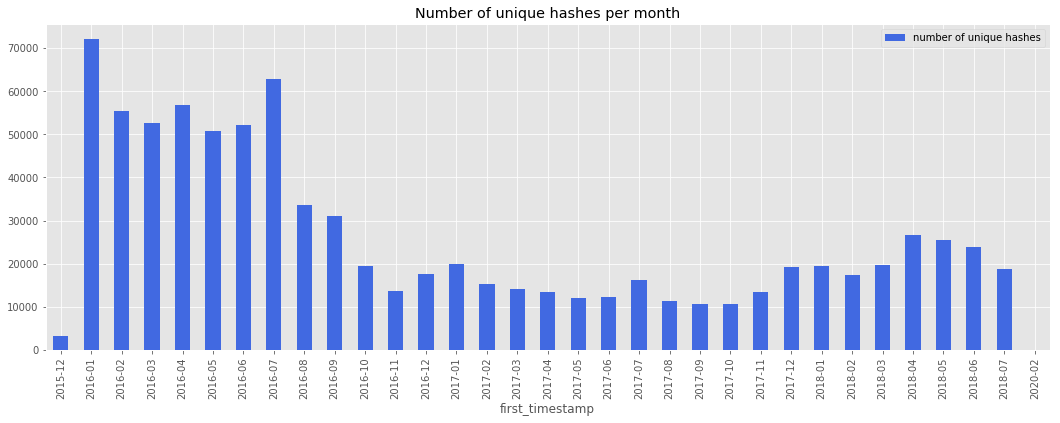

In [44]:
first_uniqueHashes = monthly_cycles.copy().groupby('first_timestamp').hash.nunique()
first_uniqueHashes = first_uniqueHashes.reset_index()
first_uniqueHashes = first_uniqueHashes.rename({'hash': 'number of unique hashes'}, axis=1)
first_uniqueHashes['first_timestamp'] = first_uniqueHashes['first_timestamp'].astype('O')
first_uniqueHashes.plot.bar('first_timestamp','number of unique hashes', color='royalblue', figsize=(18,6), title='Number of unique hashes per month')
plt.show()

The number of unique hashes per month seems to virtually follow the exact same trend, as no overly drastic changes are observed overall. Just notice the magnitude of the number of unique hashes has decreased to about **less than a quarter** of the number of the (non-unique) hashes for each month, as we expected.

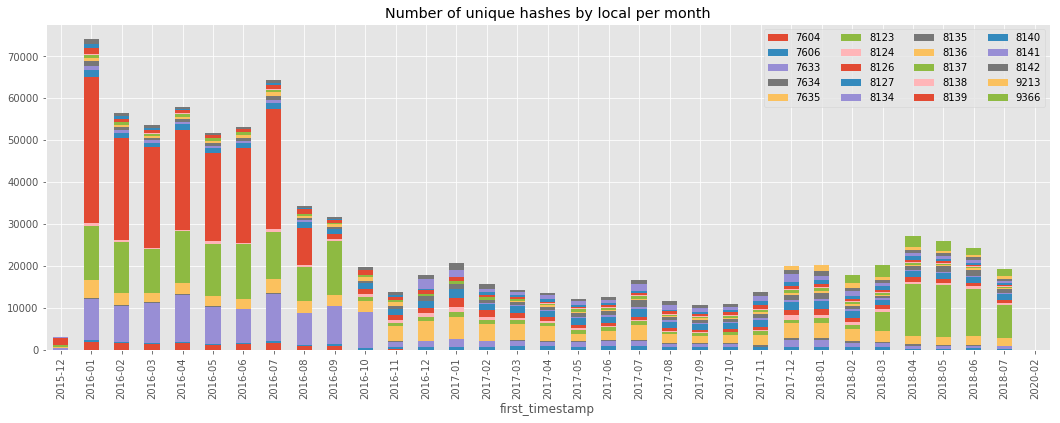

In [45]:
first_uniqueHashes_local = monthly_cycles.copy().groupby(['first_timestamp','local']).hash.nunique()
first_uniqueHashes_local = first_uniqueHashes_local.reset_index()
first_uniqueHashes_local = first_uniqueHashes_local.rename({'hash': 'number of unique hashes'}, axis=1)
first_uniqueHashes_local['first_timestamp'] = first_uniqueHashes_local['first_timestamp'].astype('O')
first_uniqueHashes_local = first_uniqueHashes_local.pivot(index='first_timestamp', columns='local', values='number of unique hashes')
first_uniqueHashes_local.plot.bar(stacked=True, figsize=(18,6), title='Number of unique hashes by local per month')
plt.legend(ncol=4)
plt.show()

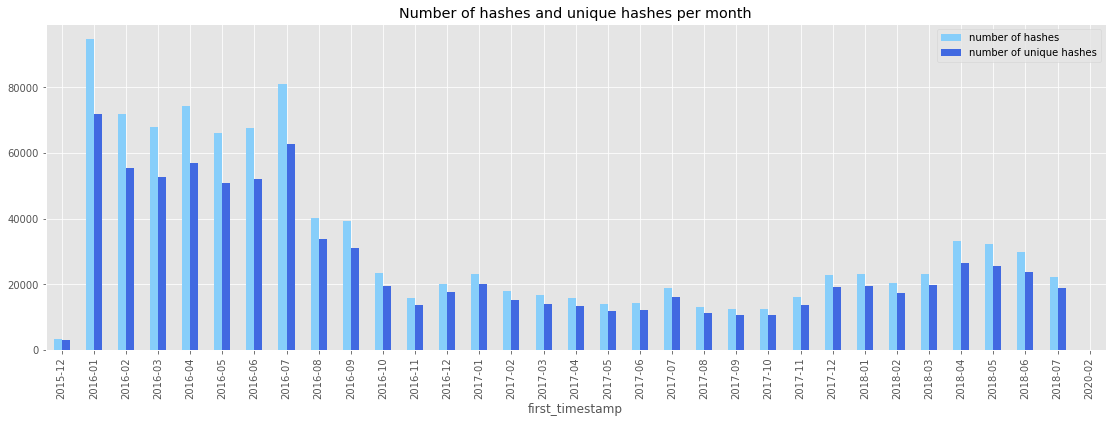

In [46]:
first_hashes_uniqueHashes = pd.merge(first_hashes, first_uniqueHashes, how='outer', left_on=['first_timestamp'], right_on=['first_timestamp'])
first_hashes_uniqueHashes.plot.bar('first_timestamp', color=['lightskyblue','royalblue'], figsize=(19,6), title='Number of hashes and unique hashes per month')
plt.show()

When jointly plotting both the number of hashes and unique hashes, the drop of **less than a quarter** of the hashes in the number of unique hashes per month is more or less notable, as we stated above, but not very accentuated. Furthermore, this difference is kept throughout every month, with barely noticeable differences (it is only perceivable in 2016, when there are too many tickets).

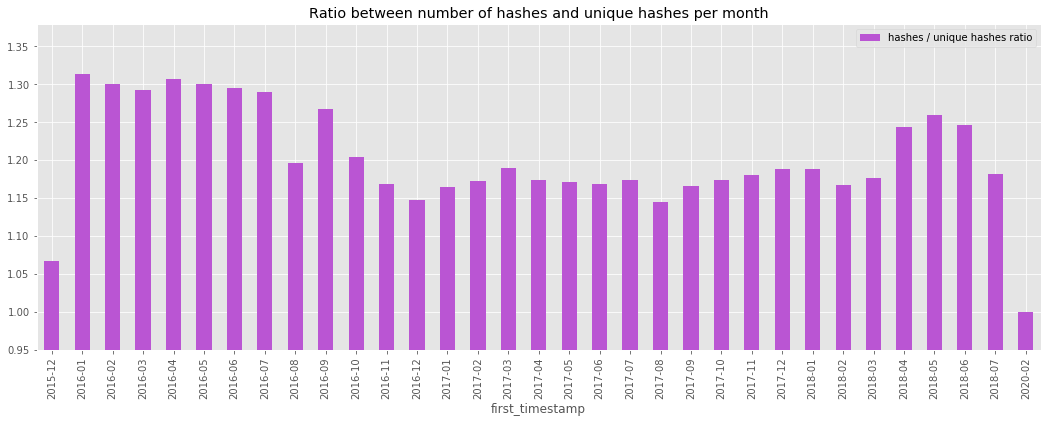

In [47]:
first_hashes_uniqueHashes['hashes / unique hashes ratio'] = first_hashes_uniqueHashes['number of hashes'] / first_hashes_uniqueHashes['number of unique hashes']
first_hashes_uniqueHashes.plot.bar('first_timestamp','hashes / unique hashes ratio', color='mediumorchid', figsize=(18,6),
                                  title='Ratio between number of hashes and unique hashes per month')
plt.ylim(bottom=min(first_hashes_uniqueHashes['hashes / unique hashes ratio'])-0.05)
plt.show()

The ratio between the number of hashes and the number of unique hashes per month reflects the constant difference between the number of hashes and unique hashes each month. Moreover, now it is perceived how much does this proportion represent: not more than **1.20** and very near to **1**, in average.

#### 5.3. Jointly evolution of Tickets and Cycles dataframes

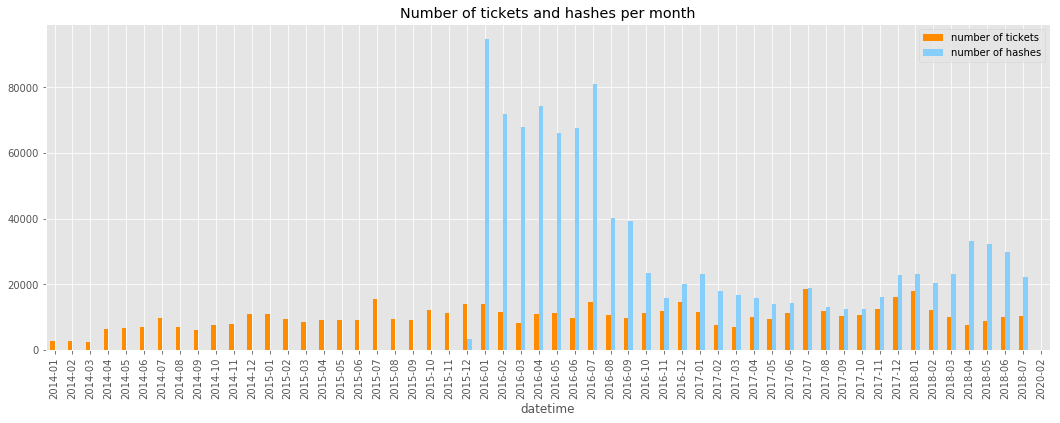

In [48]:
first_tickets_hashes = pd.merge(datetime_tickets, first_hashes, how='outer', left_on=['datetime'], right_on=['first_timestamp'])
first_tickets_hashes['datetime'] = first_tickets_hashes['datetime'].fillna(first_tickets_hashes['first_timestamp'])
first_tickets_hashes = first_tickets_hashes.drop(['first_timestamp'], axis=1)
first_tickets_hashes.plot.bar('datetime', color=['darkorange','lightskyblue'], figsize=(18,6), title='Number of tickets and hashes per month')
plt.show()

When jointly plotting the period of time of the Tickets dataset and the one of the Cycles dataframe, two very important things impact us: the first one, there exists a gap between years 2014 and 2015 for which we do not have any Cycles data, hence cannot be matched to any hash. The second one, the difference between the number of hashes and tickets is hugemongous and strongly variable.

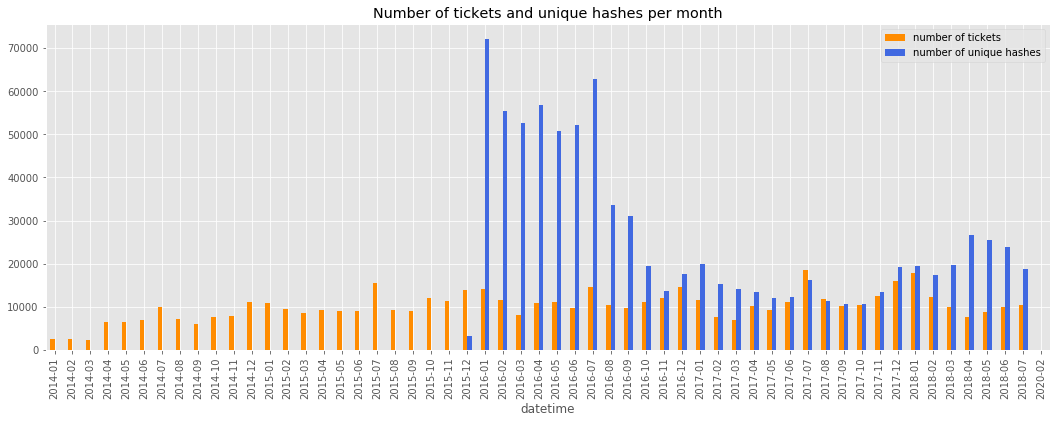

In [49]:
first_tickets_uniqueHashes = pd.merge(datetime_tickets, first_uniqueHashes, how='outer', left_on=['datetime'], right_on=['first_timestamp'])
first_tickets_uniqueHashes['datetime'] = first_tickets_uniqueHashes['datetime'].fillna(first_tickets_uniqueHashes['first_timestamp'])
first_tickets_uniqueHashes = first_tickets_uniqueHashes.drop(['first_timestamp'], axis=1)
first_tickets_uniqueHashes.plot.bar('datetime', color=['darkorange','royalblue'], figsize=(18,6), title='Number of tickets and unique hashes per month')
plt.show()

The comparison between the number of tickets and the number of unique hashes per month follows the same trend stated above. Just with a smaller magnitude as seen in other cases.

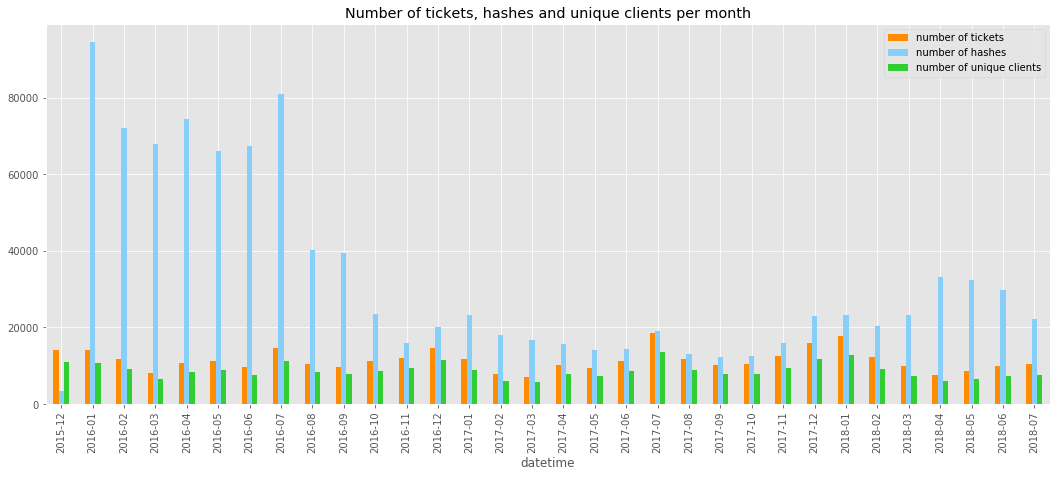

In [50]:
datetime_tickets_hashes_clients = pd.merge(first_tickets_hashes.dropna(), datetime_clients, how='left', left_on=['datetime'], right_on=['datetime'])
datetime_tickets_hashes_clients.plot.bar('datetime', color=['darkorange','lightskyblue','limegreen'], figsize=(18,7), title='Number of tickets, hashes and unique clients per month')
plt.show()

Showing together the three related variables: tickets, hashes and unique clients, we observe that while the number of unique clients is
near the same as the number of tickets, when we compare to hashes the difference is abysmal, specially for the year 2016 which has too many hashes.

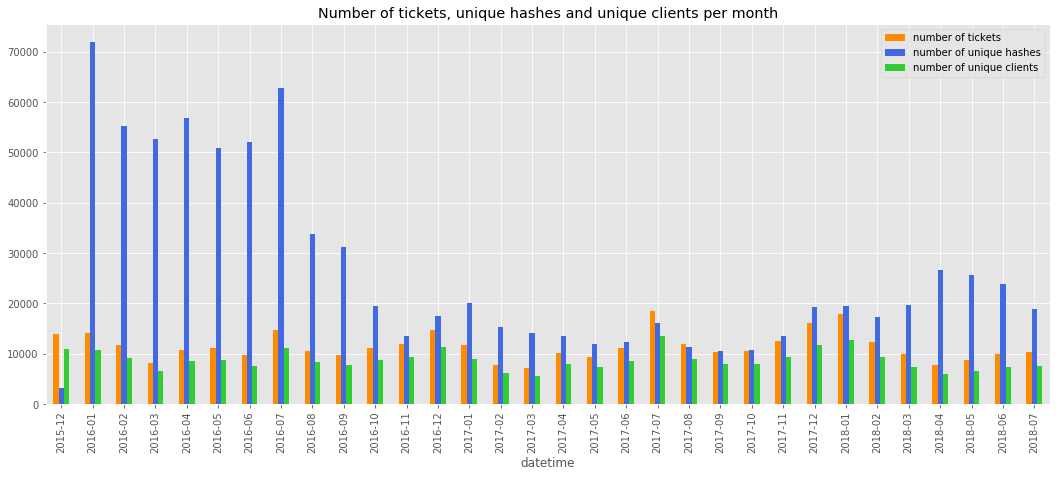

In [51]:
datetime_tickets_uniqueHashes_clients = pd.merge(first_tickets_uniqueHashes.dropna(), datetime_clients, how='left', left_on=['datetime'], right_on=['datetime'])
datetime_tickets_uniqueHashes_clients.plot.bar('datetime', color=['darkorange','royalblue','limegreen'], figsize=(18,7), title='Number of tickets, unique hashes and unique clients per month')
plt.show()

When comparing the number of tickets and unique clients with the unique hashes, figures comforts us a little bit. It is true that proportions between tickets, hashes and clients follow the same fashion as before every month. Just say the number of unique hashes has decreased a couple of thousands, but the a high variability still exists. 

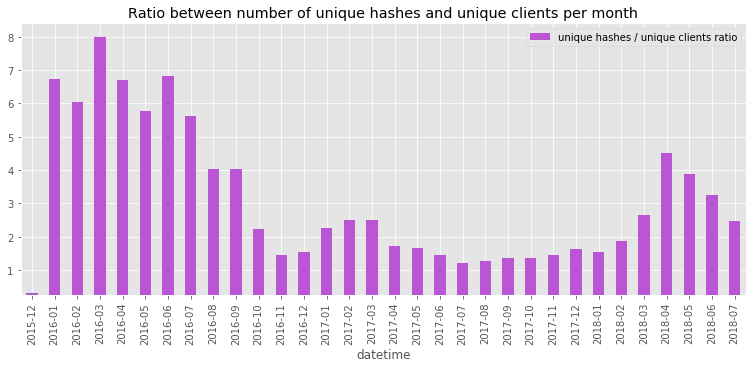

In [52]:
datetime_tickets_uniqueHashes_clients['unique hashes / unique clients ratio'] = datetime_tickets_uniqueHashes_clients['number of unique hashes'] / datetime_tickets_uniqueHashes_clients['number of unique clients']
datetime_tickets_uniqueHashes_clients.plot.bar('datetime','unique hashes / unique clients ratio', color='mediumorchid', figsize=(13,5),
                                  title='Ratio between number of unique hashes and unique clients per month')
plt.ylim(bottom=min(datetime_tickets_uniqueHashes_clients['unique hashes / unique clients ratio'])-0.05)
plt.show()

The ratio between the number of unique hashes and unique clients per month reflects the high variability stated above among different time periods. For instance, for some months the ratio exceeds the **6** points and for other barely reaches **2**. So, we cannot determine which is the univocal amount of hashes that can be matched to a unique client, as basically, this value really depends on the year.

### 6. Intersection with Segmentation's hashes

In [53]:
unique_hashes_crm = cycles['hash'].unique()
unique_hashes_seg = np.load(DATA_PATH + 'unique_hashes.npy')
intersec = set(np.intersect1d(unique_hashes_crm, unique_hashes_seg))

In [54]:
df = pd.DataFrame([len(unique_hashes_crm), len(unique_hashes_seg), len(intersec)], index=['matching','segmentation','INTERSEC'])
df = df.rename({0: 'number of unique hashes'}, axis=1)
df['intersection pct %'] = len(intersec) / df['number of unique hashes'] * 100
df

,number of unique hashes,intersection pct %
matching,540970,22.902194
segmentation,16433237,0.753923
INTERSEC,123894,100.000000
